# Preprocessing

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [139]:
import sys

sys.path.append("../scripts/")

import os
import pandas as pd
import nibabel as nib
import numpy as np
import shutil

from utils import *
from ppmi import *
from pathlib import Path
from PIL import Image
from collections import Counter, defaultdict
from nilearn import plotting, image as nim

In [3]:
DATA_DIR = Path("/home/eager/data/PPMI/")

In [4]:
df = pd.read_csv(DATA_DIR / "all_mri_t2_axial_metadata.csv")

In [5]:
df = df.rename(columns=PPMI_META_RENAME_DICT)

In [6]:
df[df["iid"] == 1196823]

,iid,pid,group,Sex,age,visit,modality,desc,type,acq_date,fmt,downloaded
15,1196823,75508,GenCohort Unaff,F,58,1,MRI,AX T2 Flair,Original,11/28/2018,DCM,NaN


In [7]:
df[df["iid"] == 1196822]

,iid,pid,group,Sex,age,visit,modality,desc,type,acq_date,fmt,downloaded
14,1196822,75508,GenCohort Unaff,F,58,1,MRI,Axial PD/T2,Original,11/28/2018,DCM,NaN


In [9]:
len(set(df["iid"]))

2704

In [ ]:
len(df)

## Checking difference between file IDs from the files and those in the CSV

In [10]:
MRI_FLAT = Path(os.environ["HOME"] + "/modeling-parkinsons/data/raw/mri_flattened")

In [11]:
all_mris = list(MRI_FLAT.glob("*"))

In [12]:
all_mris[0]

PosixPath('/home/eager/modeling-parkinsons/data/raw/mri_flattened/PPMI_41486_MR_Axial_PD-T2_TSE_FS_br_raw_20150831085847326_85_S270815_I507839.nii')

In [13]:
get_pat_img_id_from_fname(all_mris[0].name)

(41486, 507839)

In [26]:
filesystem_img_ids = [] # images that we have on the filesystem

for fname in all_mris:
    pid, iid = get_pat_img_id_from_fname(fname.name)
    filesystem_img_ids.append(iid)

In [27]:
metadata_img_ids = list(df["iid"])

In [28]:
len(metadata_img_ids), len(filesystem_img_ids)

(2704, 2152)

Note: there are 552 missing files on the filesystem (have metadata entries, but no file; TODO: investigate why)

In [36]:
missing_img_ids = list(set(metadata_img_ids) - set(filesystem_img_ids))

In [38]:
get_img_info_from_iid(df, missing_img_ids[0])

,iid,pid,group,Sex,age,visit,modality,desc,type,acq_date,fmt,downloaded
940,415752,3870,PD,F,43,5,MRI,Axial PD-T2 TSE FS,Original,1/15/2014,DCM,NaN


### Extract center images from Nii files to PNG

In [51]:
img = nib.load(get_fname_from_iid(10874, "../data/raw/mri_flattened", debug=True))

Retrieved file: ../data/raw/mri_flattened/PPMI_10874_MR__AX_FSE_T2_br_raw_20141105114806459_4_S235827_I451000.nii


In [52]:
img

In [53]:
img.get_fdata().shape

(512, 512, 25, 1)

### Dimension statistics

In [99]:
img_dir = "/home/eager/modeling-parkinsons/data/png/mri_flattened_center/"
img_paths = list(Path(img_dir).glob("*.png"))

In [68]:
img_size_ctr = Counter()

for img_path in img_paths:
    img = Image.open(img_path)
    width, height = img.size
    img_size_ctr[(width, height)] += 1

In [69]:
img_size_ctr

Counter({(240, 192): 10,
         (256, 232): 104,
         (256, 228): 735,
         (256, 256): 222,
         (240, 176): 246,
         (512, 512): 198,
         (240, 175): 3,
         (560, 560): 34,
         (256, 204): 59,
         (116, 116): 336,
         (256, 192): 69,
         (228, 256): 43,
         (240, 256): 3,
         (240, 240): 31,
         (288, 288): 5,
         (512, 384): 5,
         (256, 176): 40,
         (320, 320): 1,
         (512, 392): 1,
         (232, 256): 1,
         (128, 128): 1,
         (204, 256): 1})

In [84]:
img_size_types = defaultdict(set)

for img_path in img_paths:
    img = Image.open(img_path)
    width, height = img.size
    pid, iid = get_pid_iid_from_fname(img_path.name)
    type_ = str(get_img_info_from_iid(df, iid)["type"])
    img_size_types[(width, height)].add(type_)

In [85]:
img_size_types

defaultdict(set,
            {(240, 192): {'Processed'},
             (256, 232): {'Original'},
             (256, 228): {'Original'},
             (256, 256): {'Original'},
             (240, 176): {'Processed'},
             (512, 512): {'Original'},
             (240, 175): {'Processed'},
             (560, 560): {'Original'},
             (256, 204): {'Original'},
             (116, 116): {'Processed'},
             (256, 192): {'Original'},
             (228, 256): {'Original'},
             (240, 256): {'Processed'},
             (240, 240): {'Original'},
             (288, 288): {'Original'},
             (512, 384): {'Original'},
             (256, 176): {'Processed'},
             (320, 320): {'Original'},
             (512, 392): {'Original'},
             (232, 256): {'Original'},
             (128, 128): {'Original'},
             (204, 256): {'Original'}})

In [86]:
get_img_info_from_iid(df, 310301)["type"]

'Original'

In [101]:
img_size_iids = defaultdict(set)

for img_path in img_paths:
    img = Image.open(img_path)
    width, height = img.size
    pid, iid = get_pid_iid_from_fname(img_path.name)
    type_ = str(get_img_info_from_iid(df, iid)["type"])
    
    if type_ == 'Original':
        img_size_iids[(width, height)].add(iid)

### Keep only the original images

In [143]:
indir = "/home/eager/modeling-parkinsons/data/png/mri_flattened_center/"
original_iids = set(df[df["type"] == "Original"]["iid"])

In [149]:
outdir = Path("/home/eager/modeling-parkinsons/data/png/mri_flattened_center_original/")
ipaths = Path(indir).glob("*.png")

for ipath in ipaths:
    img = Image.open(ipath)
    width, height = img.size
    pid, iid = get_pid_iid_from_fname(ipath.name)
    
    size_dir = outdir / f"{width}x{height}"
    all_dir = outdir / "all_sizes"
    
    safemakedir(size_dir)
    
    if iid in original_iids:
        shutil.copy(ipath, size_dir)
        shutil.copy(ipath, all_dir)

### Checking Affines

In [92]:
nii_dir = Path("/home/eager/modeling-parkinsons/data/raw/mri_flattened/")

In [93]:
all_niis = list(nii_dir.glob("*.nii"))

In [106]:
desired_size = (256, 228)
desired_size_iids = list(img_size_iids[desired_size])
print(len(desired_size_iids))

735


In [109]:
niimg = nib.load(get_fname_from_iid(desired_size_iids[0], nii_dir))
niimg.affine

In [111]:
niimg2 = nib.load(get_fname_from_iid(desired_size_iids[1], nii_dir))
niimg2.affine

array([[  0.9375    ,   0.        ,   0.        , 332.35687256],
       [  0.        ,   0.9375    ,   0.        , 379.50924683],
       [  0.        ,   0.        ,   3.        , -62.60510635],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

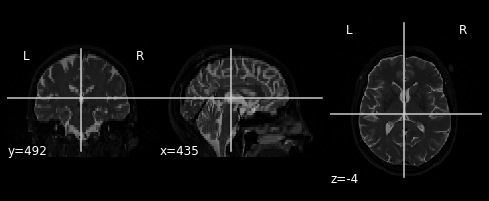

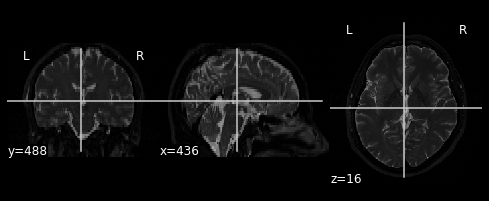

In [121]:
plotting.plot_anat(niimg)
plotting.plot_anat(niimg2)

In [119]:
niimg2_resample = nim.resample_img(niimg2, niimg.affine)

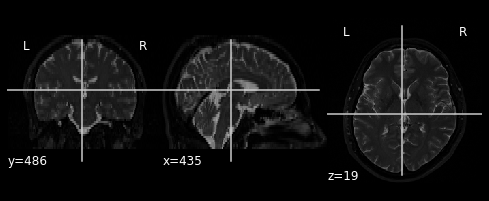

In [120]:
plotting.plot_anat(niimg2_resample)

In [126]:
# "average" affine?
avg_affine = np.zeros((4, 4))
for iid in desired_size_iids:
    avg_affine += nib.load(get_fname_from_iid(iid, nii_dir)).affine
avg_affine /= len(desired_size_iids)

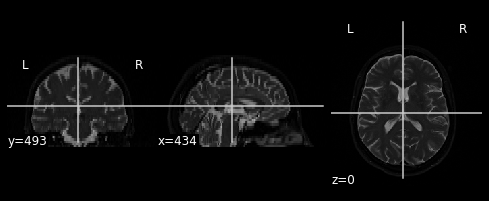

In [129]:
def plot_resampled(niimg, affine):
    niimg_resample = nim.resample_img(niimg, affine)
    plotting.plot_anat(niimg_resample)

plot_resampled(niimg, avg_affine)

In [134]:
big_img_iids = list(img_size_iids[(512, 512)])

In [136]:
niimg_large = get_img_from_iid(big_img_iids[0], nii_dir)

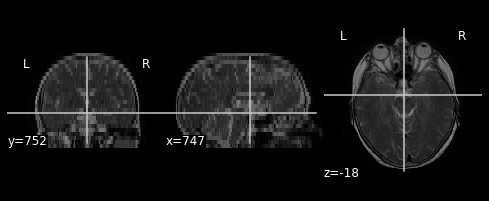

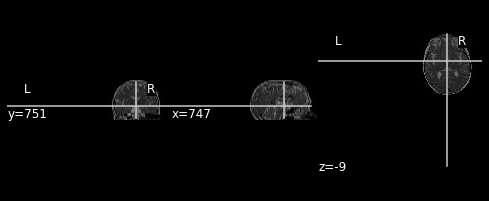

In [138]:
plotting.plot_anat(niimg_large)
plot_resampled(niimg_large, avg_affine)

### Statistics on split

In [152]:
group_stats = defaultdict(set)

for iid in original_iids:
    group = get_img_info_from_iid(df, iid)["group"]
    group_stats[group].add(iid)

In [153]:
for group, iids in group_stats.items():
    print(f"{group}, {len(iids)}")

PD, 879
GenCohort Unaff, 297
GenCohort PD, 182
Control, 327
Prodromal, 97
SWEDD, 113
GenReg Unaff, 3
GenReg PD, 2
